# MovoieLens Recommender System:

# (1) IMPORTS & SET-UPS

In [3]:
import os
import gc
import warnings
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import faiss

# Configs
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

DATA_DIR = Path("../data/raw")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# (2) Data Loading:

convert to parquet to be memory efficient:

In [4]:
#ratings = pd.read_csv(r'../data/raw/ratings.csv', dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})
#movies = pd.read_csv(r'../data/raw/movies.csv')

In [5]:
#ratings.to_parquet("../data/raw/ratings.parquet")
#movies.to_parquet("../data/raw/movies.parquet")

In [6]:
ratings = pd.read_parquet(DATA_DIR / "ratings.parquet")
movies = pd.read_parquet(DATA_DIR / "movies.parquet")


In [7]:
ratings['userId'] = ratings['userId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating'] = ratings['rating'].astype('float32')

In [8]:
print(f"Ratings Shape: {ratings.shape}")
print(f"Movies Shape: {movies.shape}")
ratings.head()

Ratings Shape: (32000204, 4)
Movies Shape: (87585, 3)


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


## EDA & Data Analysis:

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int64  
dtypes: float32(1), int32(2), int64(1)
memory usage: 610.4 MB


In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies['genres'] = movies['genres'].str.replace('|', ' ')


In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")

Ratings shape: (32000204, 4)
Movies shape: (87585, 3)


In [15]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

In [16]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 32000204
Number of unique movieId's: 84432
Number of unique users: 200948
Average number of ratings per user: 159.25
Average number of ratings per movie: 379.01


In [17]:
print(ratings.isnull().sum(), movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 movieId    0
title      0
genres     0
dtype: int64


In [18]:
print(ratings.duplicated().sum(), movies.duplicated().sum())

0 0


* How many ratings did each user make?

In [19]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,141
1,2,52
2,3,147
3,4,27
4,5,33


In [20]:
mean_n_ratings = user_freq['n_ratings'].mean()
print(f"Mean number of ratings for a given user = {mean_n_ratings:.2f}.")

Mean number of ratings for a given user = 159.25.


* Distribution of movie ratings:

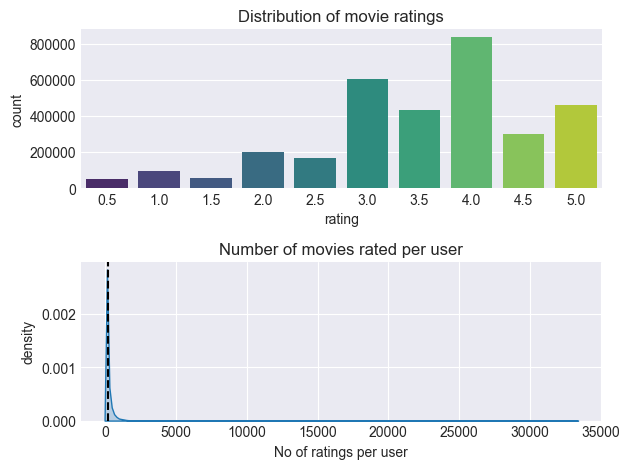

In [21]:
sampled_ratings = ratings.sample(frac=0.1, random_state=42)
from os import set_handle_inheritable
plt.subplot(2,1,1)
ax = sns.countplot(x='rating', data= sampled_ratings, palette='viridis')
ax.set(title = 'Distribution of movie ratings')

plt.subplot(2,1,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade = True, legend= False)
ax.set(title = "Number of movies rated per user", xlabel="No of ratings per user", ylabel="density")
ax.axvline(user_freq['n_ratings'].mean(), color = "k", linestyle = '--')

plt.tight_layout()
plt.show()

In [22]:
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}"),

Mean global rating: 3.5399999618530273


(None,)

In [23]:
mean_ratings = ratings.groupby(by ='userId')['rating'].mean()
print(f"Mean rating per user = {round(mean_ratings.mean(),2 )}")

Mean rating per user = 3.700000047683716


* What are the heightest and lowest rated movies?

In [24]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
mean_rating.head()

,rating
movieId,
1,3.897438
2,3.275758
3,3.139447
4,2.845331
5,3.059602


In [25]:
lowest_rated = mean_rating['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
5694,5805,Besotted (2001),Drama


In [26]:
highest_rated = mean_rating['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
9644,31945,Always a Bridesmaid (2000),Documentary


In [27]:
ratings[ratings['movieId'] == highest_rated] # it only has one rating!

,userId,movieId,rating,timestamp
14497441,90716,31945,5.0,1553102189


* Which movies are most frequently rated ?

In [28]:
movie_rating = ratings.merge(right= movies, on ='movieId')
movie_rating['title'].value_counts().head(10)

title
Shawshank Redemption, The (1994)                             102929
Forrest Gump (1994)                                          100296
Pulp Fiction (1994)                                           98409
Matrix, The (1999)                                            93808
Silence of the Lambs, The (1991)                              90330
Star Wars: Episode IV - A New Hope (1977)                     85010
Fight Club (1999)                                             77332
Jurassic Park (1993)                                          75233
Schindler's List (1993)                                       73849
Lord of the Rings: The Fellowship of the Ring, The (2001)     73122
Name: count, dtype: int64

## Feature Engineering:

- Bayesian Average:
$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$


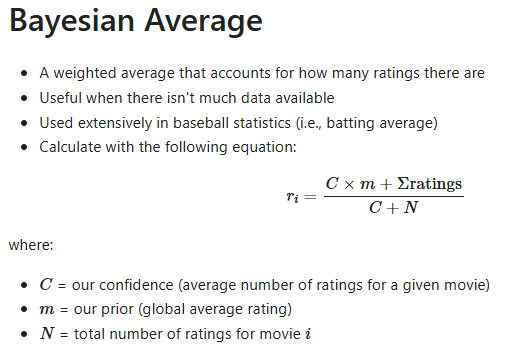

In [29]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

movie_stats['bayesian_avg'] = (
    (C * m) + (movie_stats['mean'] * movie_stats['count'])
) / (C + movie_stats['count'])

movies = movies.merge(movie_stats, on='movieId', how='left')
movies['bayesian_avg'] = movies['bayesian_avg'].fillna(m)

movies.sort_values('bayesian_avg', ascending=False).head()

,movieId,title,genres,count,mean,bayesian_avg
314,318,"Shawshank Redemption, The (1994)",Crime Drama,102929.0,4.404614,4.399480
840,858,"Godfather, The (1972)",Crime Drama,66440.0,4.317030,4.309589
40985,159817,Planet Earth (2006),Documentary,2948.0,4.444369,4.280408
61090,202439,Parasite (2019),Comedy Drama,11670.0,4.312253,4.271136
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,67750.0,4.265070,4.258061


* Which movies has the heightest bayesian average rating?

In [30]:
movies[['title', 'bayesian_avg']].sort_values('bayesian_avg', ascending= False).head()

,title,bayesian_avg
314,"Shawshank Redemption, The (1994)",4.399480
840,"Godfather, The (1972)",4.309589
40985,Planet Earth (2006),4.280408
61090,Parasite (2019),4.271136
49,"Usual Suspects, The (1995)",4.258061


In [31]:
movies[['title', 'bayesian_avg']].sort_values('bayesian_avg', ascending= True).head()

,title,bayesian_avg
3495,Battlefield Earth (2000),1.668386
4670,Glitter (2001),1.754783
6465,Gigli (2003),1.764941
11353,Epic Movie (2007),1.775485
9607,Son of the Mask (2005),1.779053


In [32]:
gc.collect()


18

## Collaborative Filtering System [Logic A]: 

* Transforming Data:(User-Item matrix)

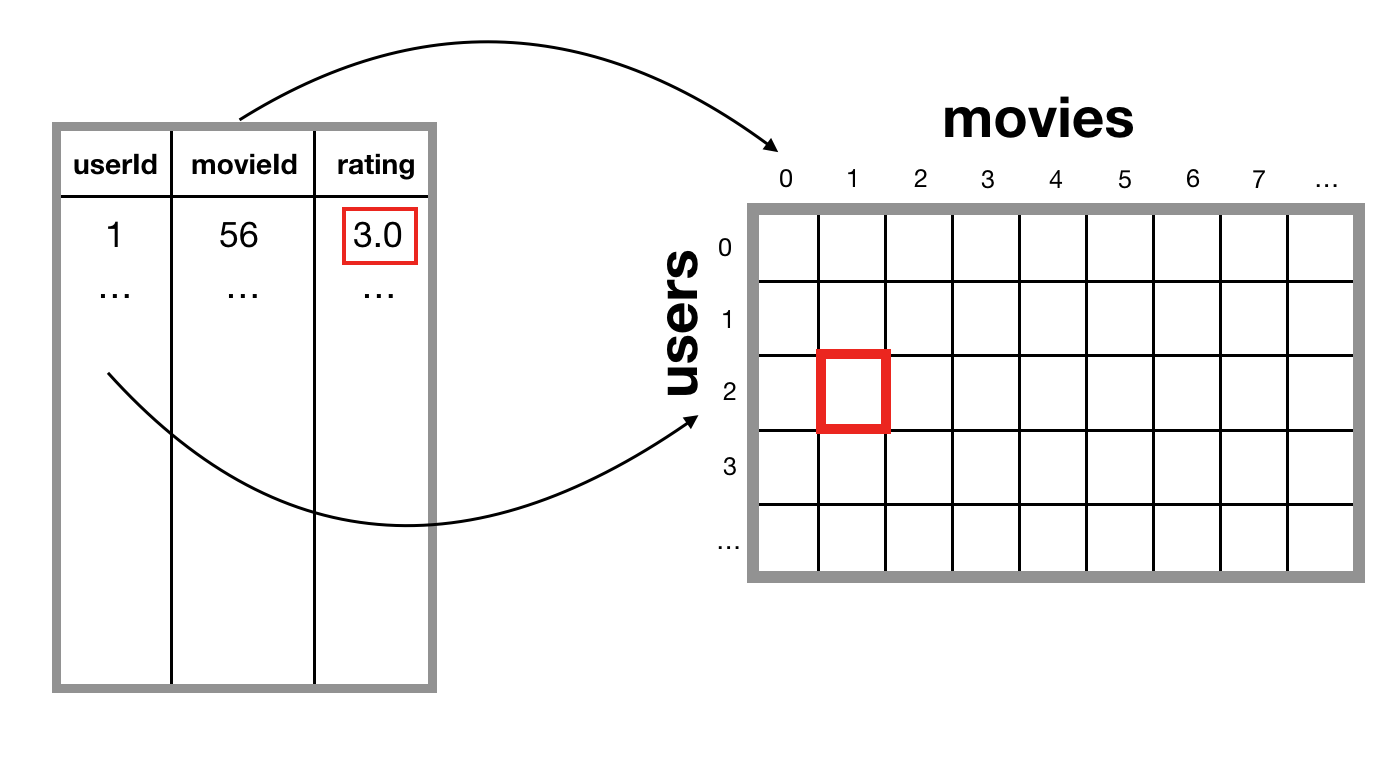

In [33]:
# Mappings
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_mapper = {id: i for i, id in enumerate(user_ids)}
movie_inv_mapper = {i: id for i, id in enumerate(movie_ids)}
movie_mapper = {id: i for i, id in enumerate(movie_ids)}


In [34]:
# Sparse Matrix
# 1. Calculate User Means
user_means = ratings.groupby('userId')['rating'].mean()
ratings['centered_rating'] = ratings['rating'] - ratings['userId'].map(user_means)

# 2. Create Matrix with Centered Data
row_ind = [movie_mapper[i] for i in ratings['movieId']]
col_ind = [user_mapper[i] for i in ratings['userId']]
data = ratings['centered_rating'].values  # Use the centered column

X = csr_matrix((data, (row_ind, col_ind)), shape=(len(movie_ids), len(user_ids)), dtype=np.float32)

print(f"Matrix X created with shape {X.shape}")

Matrix X created with shape (84432, 200948)


In [35]:
# Train SVD
svd = TruncatedSVD(n_components=150, n_iter=7, random_state=42)
movie_vectors = svd.fit_transform(X)

In [36]:
# Faiss Index
movie_vectors_normalized = movie_vectors.copy()
faiss.normalize_L2(movie_vectors_normalized)

d = movie_vectors_normalized.shape[1] 
index = faiss.IndexFlatIP(d) 

index.add(movie_vectors_normalized)
print(f"Index created with dimension: {d}")

Index created with dimension: 150


In [37]:
# Calculate Sparsity of matrix: (Non-Zero / Total)
density = X.count_nonzero() / (X.shape[0] * X.shape[1])

print(f"Matrix Density: {round(density*100, 2)}%")
print(f"Matrix Sparsity: {round((1-density)*100, 2)}%")

Matrix Density: 0.19%
Matrix Sparsity: 99.81%


* Save Sparse Matrix

In [38]:
save_npz(r"../data/preprocessed/user_item_matrix.npz", X)

In [39]:
X = load_npz(r'../data/preprocessed/user_item_matrix.npz')
X

<84432x200948 sparse matrix of type '<class 'numpy.float32'>'
	with 32000204 stored elements in Compressed Sparse Row format>

## Content-Based System [Logic B]:

In [40]:
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

TF-IDF Matrix Shape: (87585, 23)


## Hybrid Approach System:

Logic:
1. Check if user exists.
2. If YES: Use SVD (Logic A).
3. If NO: Use Bayesian Top-N (Logic B Fallback).

In [41]:
def get_recommendations(user_id, k=10):
    # Path A: Existing User
    if user_id in user_mapper:
        user_idx = user_mapper[user_id]
        user_vector = svd.components_[:, user_idx]
        scores = movie_vectors.dot(user_vector)
        
        # Sort top K
        top_indices = np.argsort(scores)[::-1][:k]
        
        results = []
        for idx in top_indices:
            movie_id = movie_inv_mapper[idx]
            info = movies[movies['movieId'] == movie_id].iloc[0]
            results.append({'title': info['title'], 'score': scores[idx], 'type': 'Personalized'})
            
        return pd.DataFrame(results)

    # Path B: Cold Start
    else:
        top_movies = movies.sort_values('bayesian_avg', ascending=False).head(k)
        return top_movies[['title', 'genres', 'bayesian_avg']]

#### Testing:

In [45]:
def hybrid_recommend(user_id, alpha=0.6, k=10):
    # 1. Get SVD Scores (Shape: 84,432)
    user_idx = user_mapper[user_id]
    user_vec = svd.components_[:, user_idx]
    svd_scores = movie_vectors.dot(user_vec)

    # 2. Get Popularity Scores (Aligned to SVD)
    pop_scores = np.zeros(len(svd_scores))

    bayes_lookup = dict(zip(movies['movieId'], movies['bayesian_avg']))

    for idx, movie_id in movie_inv_mapper.items():
        if movie_id in bayes_lookup:
            pop_scores[idx] = bayes_lookup[movie_id]

    # 3. Normalize (0-1 Scale)
    svd_min, svd_max = svd_scores.min(), svd_scores.max()
    pop_min, pop_max = pop_scores.min(), pop_scores.max()

    # Avoid division by zero if max == min
    if svd_max != svd_min:
        svd_norm = (svd_scores - svd_min) / (svd_max - svd_min)
    else:
        svd_norm = svd_scores

    if pop_max != pop_min:
        pop_norm = (pop_scores - pop_min) / (pop_max - pop_min)
    else:
        pop_norm = pop_scores

    # 4. Combine
    hybrid_scores = (svd_norm * alpha) + (pop_norm * (1 - alpha))

    # 5. Filter Watched
    watched_idx = X[:, user_idx].nonzero()[0]
    hybrid_scores[watched_idx] = -1.0

    # 6. Top K
    top_indices = np.argsort(hybrid_scores)[::-1][:k]

    results = []
    for idx in top_indices:
        movie_id = movie_inv_mapper[idx]
        info = movies[movies['movieId'] == movie_id].iloc[0]
        results.append({
            'title': info['title'],
            'genres': info['genres'],
            'score': round(hybrid_scores[idx], 3),
            'year': str(info['title'])[-5:-1]
        })

    return pd.DataFrame(results)

In [46]:
print("--- PURE SVD (Niche) ---")
print(get_recommendations(1))

print("\n--- HYBRID (Best of Both) ---")
print(hybrid_recommend(1, alpha=0.6))

--- PURE SVD (Niche) ---
                                               title     score          type
0          Star Wars: Episode IV - A New Hope (1977)  1.544003  Personalized
1                                  Goodfellas (1990)  1.536432  Personalized
2                                     Titanic (1997)  1.416594  Personalized
3                                 Taxi Driver (1976)  1.363991  Personalized
4                                Blade Runner (1982)  1.277837  Personalized
5          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)  1.254464  Personalized
6                          Back to the Future (1985)  1.203713  Personalized
7  Star Wars: Episode V - The Empire Strikes Back...  1.054748  Personalized
8                     Godfather: Part II, The (1974)  0.883092  Personalized
9                              Apocalypse Now (1979)  0.873490  Personalized

--- HYBRID (Best of Both) ---
                                           title  \
0                                   Alien (19

In [47]:
# Test 1: User 1 (Should be Personalized)
print("User 1 Recommendations:")
get_recommendations(user_id=1).head()

User 1 Recommendations:


,title,score,type
0,Star Wars: Episode IV - A New Hope (1977),1.544003,Personalized
1,Goodfellas (1990),1.536432,Personalized
2,Titanic (1997),1.416594,Personalized
3,Taxi Driver (1976),1.363991,Personalized
4,Blade Runner (1982),1.277837,Personalized


In [48]:
# Test 2: User 99999999 (Should Cold Start)
print("\nNew User Recommendations:")
get_recommendations(user_id=99999999).head()


New User Recommendations:


,title,genres,bayesian_avg
314,"Shawshank Redemption, The (1994)",Crime Drama,4.399480
840,"Godfather, The (1972)",Crime Drama,4.309589
40985,Planet Earth (2006),Documentary,4.280408
61090,Parasite (2019),Comedy Drama,4.271136
49,"Usual Suspects, The (1995)",Crime Mystery Thriller,4.258061


## Evaluation:

#### RMSE:

In [49]:
def calculate_rmse_sparse(X_sparse, movie_vecs, user_vecs, batch_size=10000):
    rows, cols = X_sparse.nonzero()
    n_ratings = len(rows)
    squared_error = 0
        
    for start in range(0, n_ratings, batch_size):
        end = min(start + batch_size, n_ratings)
        
        # 1. Get indices for this batch
        batch_rows = rows[start:end]
        batch_cols = cols[start:end]
        
        # 2. Get actual ratings
        actual = np.array(X_sparse[batch_rows, batch_cols]).flatten()
        
        # 3. Predict
        batch_preds = np.sum(movie_vecs[batch_rows] * user_vecs[:, batch_cols].T, axis=1)
        
        # 4. Accumulate Error
        squared_error += np.sum((actual - batch_preds) ** 2)
        
    rmse = np.sqrt(squared_error / n_ratings)
    return rmse


In [50]:
rmse = calculate_rmse_sparse(X, movie_vectors, svd.components_)
print(f"Global RMSE: {rmse:.4f}")

Global RMSE: 0.7596


#### Precision@K:

In [51]:
def train_test_split_sparse(X, test_ratio=0.2, random_state=42):
    # 1. Remove explicit zeros
    X.eliminate_zeros()
    
    np.random.seed(random_state)
    
    # 2. Get coordinates
    n_ratings = X.nnz
    n_test = int(n_ratings * test_ratio)
        
    # 3. Randomly choose indices to hide
    test_idx = np.random.choice(n_ratings, n_test, replace=False)
    
    # 4. Create Train/Test Copies
    X_train = X.copy()
    X_test = X.copy()
    
    # 5. Create Mask
    mask = np.zeros(n_ratings, dtype=bool)
    mask[test_idx] = True
    
    # 6. Apply Split
    # Train gets 0s where test data is
    X_train.data[mask] = 0
    X_train.eliminate_zeros()
    
    # Test gets 0s where train data is
    X_test.data[~mask] = 0
    X_test.eliminate_zeros()
    
    return X_train, X_test

X_train, X_test = train_test_split_sparse(X, test_ratio=0.2)
print(f"Train ratings: {X_train.nnz:,}")
print(f"Test ratings: {X_test.nnz:,}")

Train ratings: 25,535,256
Test ratings: 6,383,814


* Retrain on SVD:

In [52]:
# Train on X_train only
svd_eval = TruncatedSVD(n_components=150, n_iter=7, random_state=42)
movie_vectors_eval = svd_eval.fit_transform(X_train)

# Normalize for Cosine Similarity
faiss.normalize_L2(movie_vectors_eval)

In [53]:
def evaluate_precision_at_k(X_train, X_test, svd_model, k=10, n_users=1000):
    user_indices = np.random.choice(X_test.shape[1], n_users, replace=False)
    total_precision = 0

    for user_idx in user_indices:
        # 1. Get True Test Items
        true_test_items = set(X_test[:, user_idx].nonzero()[0])
        
        if not true_test_items:
            continue # Skip users with no test items
            
        # 2. Generate Recommendations (using Training knowledge)
        user_vec = svd_model.components_[:, user_idx]
        scores = movie_vectors_eval.dot(user_vec)
        
        # Filter things they already watched in Train
        watched_in_train = X_train[:, user_idx].nonzero()[0]
        scores[watched_in_train] = -np.inf
        
        # Get Top K
        top_k_indices = np.argsort(scores)[::-1][:k]
        
        # 3. Calculate Precision
        hits = len(set(top_k_indices) & true_test_items)
        precision = hits / k
        total_precision += precision
        
    avg_precision = total_precision / n_users
    return avg_precision

p_at_10 = evaluate_precision_at_k(X_train, X_test, svd_eval, k=10, n_users=500)
print(f"Average Precision@10: {p_at_10:.4f}")

Average Precision@10: 0.0188


## Saving Model:

In [55]:
import joblib

artifacts = {
    'svd': svd,
    'movie_vectors': movie_vectors,
    'user_mapper': user_mapper,
    'movie_inv_mapper': movie_inv_mapper,
    'user_means': user_means,
    'movies_df': movies,
    'tfidf_vectorizer': tfidf,
    'tfidf_matrix': tfidf_matrix
}

joblib.dump(artifacts, MODEL_DIR / "recommender_artifacts.pkl")

['..\\models\\recommender_artifacts.pkl']